# This notebook contains code for creating and evaluating the baseline model and subsequent models

In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score,recall_score,precision_score,fbeta_score,make_scorer,roc_auc_score,roc_curve,confusion_matrix,precision_recall_curve,classification_report
from sklearn.feature_selection import SelectFromModel

import imblearn.over_sampling

In [3]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [4]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in dataset for modeling

In [5]:
subjects_incidents = pd.read_csv('nypd_force_df_rev2.csv')

In [6]:
subjects_incidents.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'subject_age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force', 'occurrence_date',
       ...
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
       'member_injured_all_Y', 'race_diff_all_Y', 'race_diff_Y',
       'subject_injured_target'],
      dtype='object', length=101)

In [7]:
subjects_incidents['subject_injured_target'].value_counts()

0    31589
1      683
Name: subject_injured_target, dtype: int64

Drop rows with NaN in the subject age column, since logistic regression can't handle NaNs

In [8]:
subjects_incidents_no_null = subjects_incidents.dropna()

Create dataframe of features I'll actually use (plus subject_id and tri_incident_number, which are needed for splitting into train/val/split) and the target variable

In [9]:
df_X = subjects_incidents_no_null[['subject_id','tri_incident_number','subject_age',
                                   'num_subjects','num_members','race_diff_all_Y',
                                   'member_injured_all_Y',
       'member_injured_Y','race_diff_Y','subject_used_force_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','subject_injured_target']]

# Model Preparation

First, since I'm using logistic regression and I have numeric variables on different scales, I need to standardize them so they're on the same scale.

In [10]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_64423/1532820943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])


Next, I split my dataset twice: first, into training and test sets and then, from the training set into training and validation sets.

In [11]:
# split the data into train/validate/test sets with stratified sampling
    # to ensure the same proportion of the target variable in each set

# train-test split
X_train, X_te, y_train, y_te = train_test_split(df_X.iloc[:,1:], df_X['subject_injured_target'], test_size=0.2, stratify=df_X['subject_injured_target'], random_state=42)

# train-val split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [12]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{df_X["subject_injured_target"].value_counts() / len(df_X)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_tr.value_counts() / len(y_tr)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_val.value_counts() / len(y_val)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{y_te.value_counts() / len(y_te)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
0    0.978603
1    0.021397
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
0    0.978581
1    0.021419
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
0    0.978635
1    0.021365
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
0    0.978638
1    0.021362
Name: subject_injured_target, dtype: float64


Now that I have my dataset ready, I can create a helper function that will allow me to cross-validate, create an ROC curve to plot it calculate the ROC AUC score, and create confusion matrices.

In [13]:
def cross_validate_roc_cm(model, X_train, y_train, X_validate, y_validate):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recall scores: {(cv_results['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results['test_f2_score'])):.3f}")
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_validate, model.predict_proba(X_validate)[:,1]) # lr.predict_proba(X_validate)[:,1] means use probabilities for the positive outcome only

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')

    # axis labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for serious subject injury problem')
    plt.legend()
    plt.show()
    print("ROC AUC score = ", roc_auc_score(y_validate, model.predict_proba(X_validate)[:,1]))
    
    # create and plot confusion matrix with training data
    con_mat = confusion_matrix(y_train, model.predict(X_train))
    plt.figure(dpi=100)
    sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Training data')
    plt.show()
    
    # create and plot confusion matrix with validation data
    con_mat_val = confusion_matrix(y_validate, model.predict(X_validate))
    plt.figure(dpi=100)
    sns.heatmap(con_mat_val, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Validation data')
    plt.show()

In [14]:
X_tr_3 = X_tr[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','num_members','num_subjects']]

X_val_3 = X_val[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

X_te_3 = X_te[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

# Feature selection using randomly over-sampled data

In [15]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 14, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf, y_tr_os_rf = ROS.fit_resample(X_tr_3, y_tr)

In [16]:
sel = SelectFromModel(RandomForestClassifier(random_state=42))
sel.fit(X_tr_3_os_rf,y_tr_os_rf)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [17]:
sel.get_support()

array([ True,  True, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True])

In [18]:
selected_feat= X_tr_3.columns[(sel.get_support())]
len(selected_feat)

18

In [19]:
print(selected_feat)

Index(['subject_age', 'member_injured_Y', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects'],
      dtype='object')


# Random Forest Model 6 (selected features minus 'member_injured_Y')

- random over-sampling and selected features

In [20]:
X_tr_3_sel = X_tr_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

X_val_3_sel = X_val_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

X_te_3_sel = X_te_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

In [21]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 7, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf_sel, y_tr_os_rf_sel = ROS.fit_resample(X_tr_3_sel, y_tr)

recall scores: [0.99440299 1.         0.98934281 0.99084249 0.99509002]

mean recall: 0.994

f2 scores: [0.9866716  0.98443721 0.97959902 0.97759306 0.98605255]

mean f2 score: 0.983


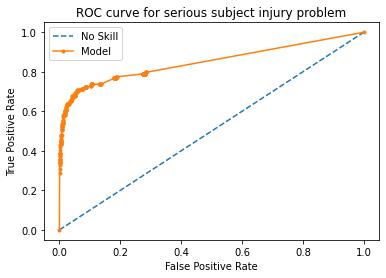

ROC AUC score =  0.8494235013008555


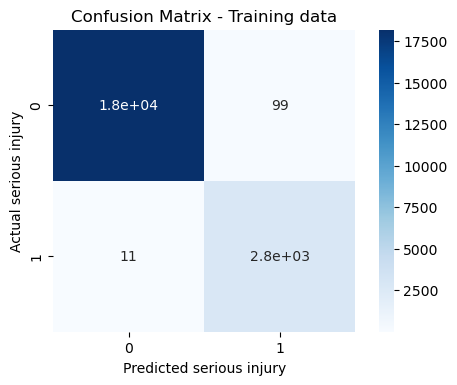

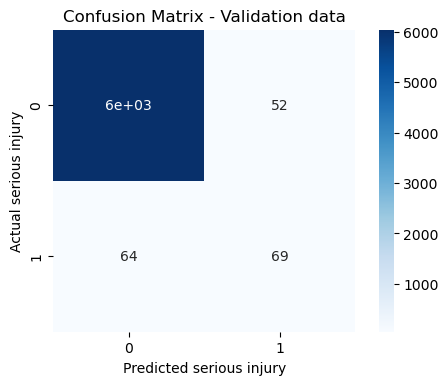

In [22]:
rf_6 = RandomForestClassifier(random_state=42)
rf_6.fit(X_tr_3_os_rf_sel,y_tr_os_rf_sel)

cross_validate_roc_cm(rf_6,X_tr_3_os_rf_sel,y_tr_os_rf_sel,X_val_3_sel,y_val)

In [23]:
X_te_3_sel = X_te_3[['subject_age','member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

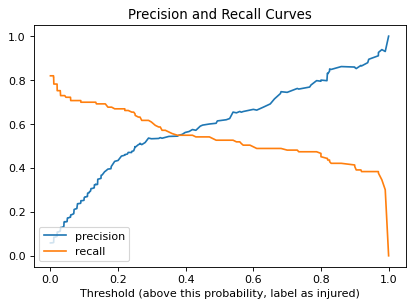

In [24]:
#plotting a precision/recall curve for different probability thresholds with the predictions

precision_curve,recall_curve,threshold_curve = precision_recall_curve(y_te,rf_6.predict_proba(X_te_3_sel)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as injured)');
plt.title('Precision and Recall Curves');

In [25]:
# calculate predicted probabilities of positive class with holdout set and adjust
    # the probability threshold to maximize recall without sacrificing 
    # the precision score too much

y_predict_rf_6 = (rf_6.predict_proba(X_te_3_sel)[:,1]>.25)
print("Precision:{:6.4f},Recall:{:6.4f},F2:{:6.4f}".format(precision_score(y_te, np.round(y_predict_rf_6)), 
                                                     recall_score(y_te, np.round(y_predict_rf_6)),
                                                     fbeta_score(y_te, np.round(y_predict_rf_6), beta=2)))

Precision:0.4943,Recall:0.6466,F2:0.6091


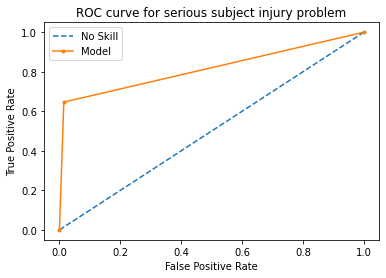

0.8160868690682886

In [26]:
# calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_te, y_predict_rf_6)

# # plot the roc curve for the model
# plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# plt.plot(fpr, tpr, marker='.', label='Model')

# # axis labels and title
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve for serious subject injury problem')
# plt.legend()
# plt.show()
# print("ROC AUC score = ", roc_curve(y_te, rf_6.predict_proba(X_te_3_sel)[:,1]>.25))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_te, (rf_6.predict_proba(X_te_3_sel)[:,1]>.25)) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Model')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()
plt.show()
roc_auc_score(y_te, (rf_6.predict_proba(X_te_3_sel)[:,1]>.25))

In [28]:
X_te_3_sel.columns

Index(['subject_age', 'member_injured_all_Y', 'race_diff_all_Y',
       'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects'],
      dtype='object')

In [29]:
X_te_3_sel.columns = ['subject_age','members_of_service_injured',
                               'subject_members_of_service_races_different',
                               'force_type_electrical_weapon','force_type_firearm',
                               'basis_for_encounter_crime/violation_in_progress',
                               'basis_for_encounter_person_in_crisis',
                               'patrol_borough_Brooklyn_North','patrol_borough_Bronx',
                               'patrol_borough_Manhattan','patrol_borough_Queens_North',
                               'subject_race_Black','subject_race_Hispanic',
                                'member_of_service_race_Hispanic',
                                'member_of_service_assignment_other','num_members_of_service',
                               'num_subjects']

Text(0.5, 1.0, 'Feature Importance in Random Forest Classifier')

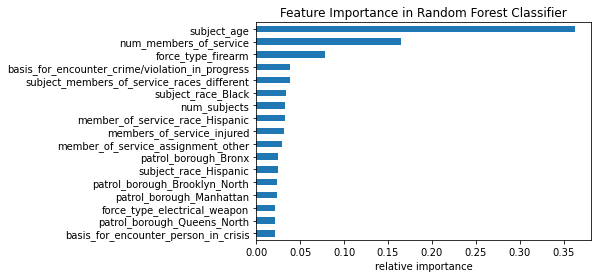

In [30]:
# plot the final 17 features in descending order of relative importance

importances = rf_6.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

feat_importances = pd.Series(rf_6.feature_importances_, index=X_te_3_sel.columns)
ax = feat_importances.nlargest(17).plot(kind='barh')
ax.invert_yaxis()
ax.set_xlabel('relative importance')
ax.set_title('Feature Importance in Random Forest Classifier')

In [31]:
X_te_3_sel['predicted_prob'] = y_predict_rf_6

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_64423/3047163984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_3_sel['predicted_prob'] = y_predict_rf_6


In [32]:
X_te_3_sel.predicted_prob.value_counts()

False    6052
True      174
Name: predicted_prob, dtype: int64

<AxesSubplot:xlabel='subject_injured_target', ylabel='subject_age'>

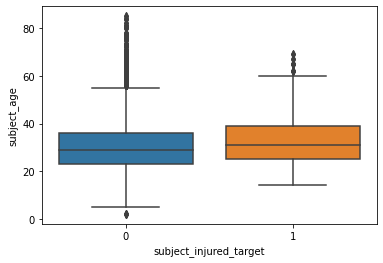

In [33]:
sns.boxplot(x='subject_injured_target', y='subject_age', data=subjects_incidents)

<AxesSubplot:xlabel='subject_injured_target', ylabel='num_members'>

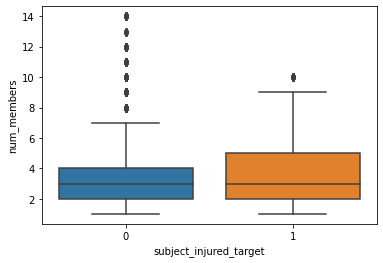

In [34]:
sns.boxplot(x='subject_injured_target', y='num_members', data=subjects_incidents)

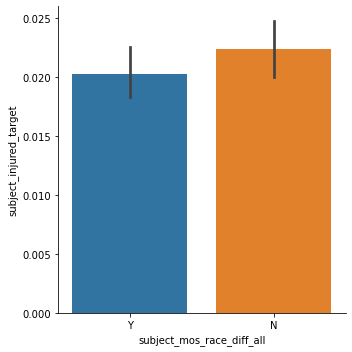

In [35]:
sns.catplot(x='subject_mos_race_diff_all',y='subject_injured_target',kind='bar',data=subjects_incidents)

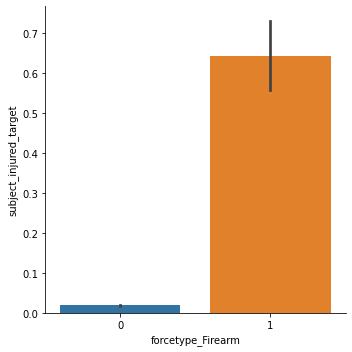

In [36]:
sns.catplot(x='forcetype_Firearm',y='subject_injured_target',kind='bar',data=subjects_incidents)